# Transfer learning: classifying food items

_Fraida Fund_


* Name: Somya Gupta
* Net ID: sg7885

This week, we practiced using transfer learning to classify hand shapes as rock, paper, or scissors.

But that was a relatively easy problem. In this notebook, we'll work on classifying photographs of food items into 11 classes: bread, dairy product, dessert, egg, fried food, meat, noodles/pasta, rice, seafood, soup, and vegetable/fruit.

This is a more challenging problem, because there is a lot of intra-class variability (e.g. different fruits and vegetables don't have a lot in common) and also some inter-class similarity (e.g. a bowl of rice can look similar to a bown of pasta).

To see what we mean by these, let's look at some examples of food photographs from the dataset that we'll work with.



Note: you can refer to this week's demo notebook for a closely related example.

Note: you may want to change the notebook's runtime type to GPU, for faster model training.


### Installing previous version of tensorflow for model.keras compatibility

In [ ]:
!pip install tensorflow==2.14.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

import tensorflow as tf

## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [2]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [3]:
!mkdir -p /content/Food-11
%cd /content/Food-11
!gdown https://drive.google.com/uc?id=1H-GV0wDcZQX7WMbPtRbwRo1_mrW_TJsC

/content/Food-11
Downloading...
From: https://drive.google.com/uc?id=1dt3CD3ICdLbTf80sNJ25TPBDKu_qyCnq
To: /content/Food-11/Food-11.zip
100% 1.16G/1.16G [00:10<00:00, 106MB/s]


In [4]:
!unzip Food-11.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/2_787.jpg      
  inflating: training/2_924.jpg      
  inflating: training/5_453.jpg      
  inflating: training/10_212.jpg     
  inflating: training/9_962.jpg      
  inflating: training/3_433.jpg      
  inflating: training/3_922.jpg      
  inflating: training/1_359.jpg      
  inflating: training/5_1145.jpg     
  inflating: training/5_204.jpg      
  inflating: training/5_1046.jpg     
  inflating: training/7_160.jpg      
  inflating: training/10_635.jpg     
  inflating: training/0_879.jpg      
  inflating: training/9_313.jpg      
  inflating: training/1_131.jpg      
  inflating: training/10_448.jpg     
  inflating: training/9_1110.jpg     
  inflating: training/8_230.jpg      
  inflating: training/5_731.jpg      
  inflating: training/0_151.jpg      
  inflating: training/2_984.jpg      
  inflating: training/2_1335.jpg     
  inflating: training/4_745.jpg      
  inflating: training/6_236.jpg      

In [5]:
%cd /content

/content


Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [11]:
training_dir = "Food-11/training/"
training_images = os.listdir(training_dir)
training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [12]:
validation_dir = "Food-11/validation/"
validation_images = os.listdir(validation_dir)
validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [13]:
evaluation_dir = "Food-11/evaluation/"
evaluation_images = os.listdir(evaluation_dir)
evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

Let's look at a few random training samples:

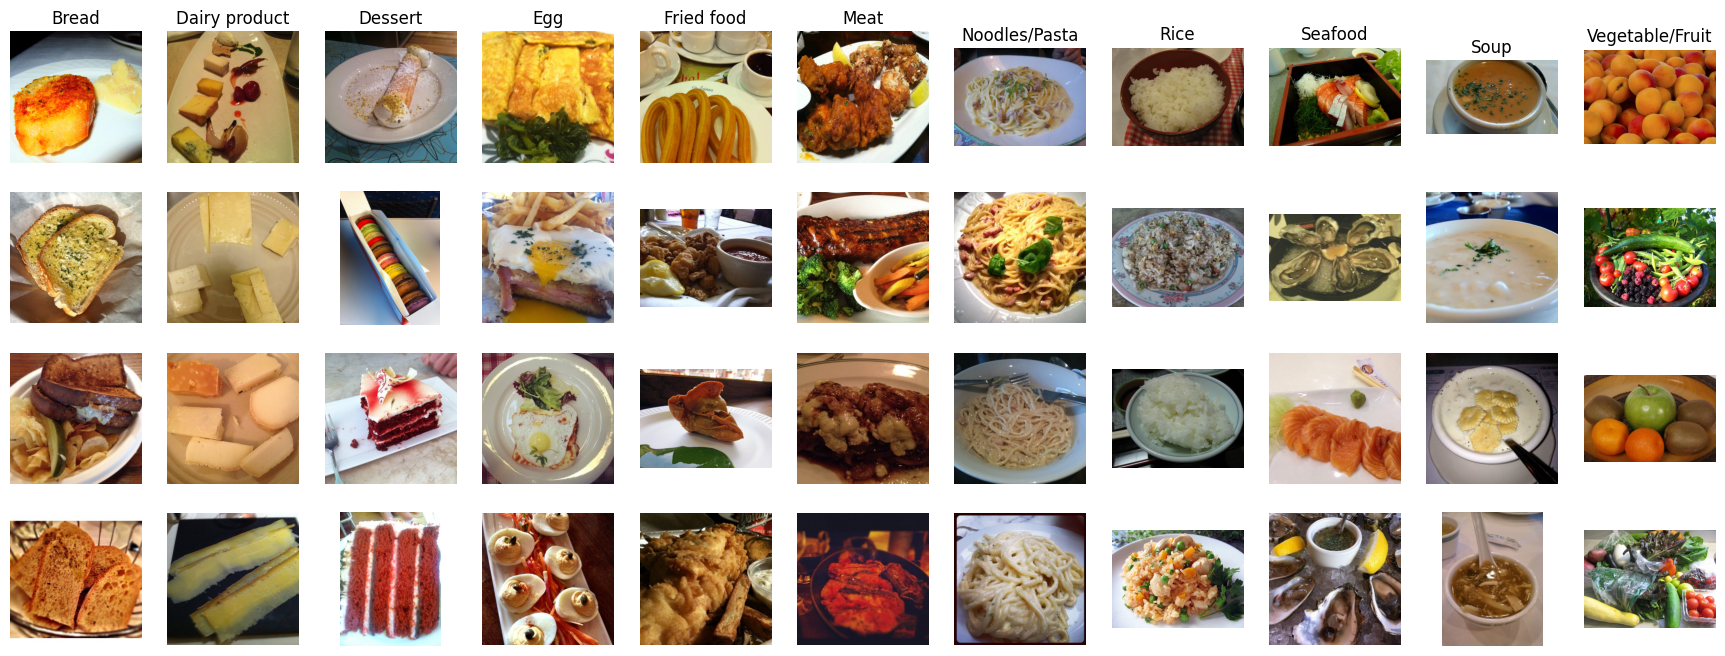

In [14]:
num_classes = len(classes)
samples_per_class = 4
figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
for cls_idx, cls in enumerate(classes):
  idxs = np.flatnonzero(training_labels == cls_idx)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_idx + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    im = Image.open(training_dir + training_images[idx])
    plt.imshow(im)
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once.

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [ ]:
#%cd /content/Food-11/training/

# loop over classes
for i in range(len(classes)):
  # make a directory for this class inside Food-11/training
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  # get list of files inside Food-11/training that have this class label
  files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
  # move each file to the subdirectory for the class
  for f in files:
    shutil.move(f, "class_%02d/" % i)

In [11]:
%cd /content/Food-11/validation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/validation


In [12]:
%cd /content/Food-11/evaluation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/evaluation


In [13]:
# go back to default working directory
%cd /content

/content


Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters, or you can keep them. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [6]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE=32
INPUT_IMG_SIZE = 224

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis.

In [16]:
# TODO 2 (optional) - design choices on image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,
	rotation_range=20,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [17]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We also set up the validation and evaluation (test) sets in a similar manner:

In [18]:
validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3430 images belonging to 11 classes.


Don't shuffle the evaluation set:

In [19]:
evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change that - you may use any model that you think will have good results.

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

In [21]:
# TODO 3 (optional) - design choice on base model

base_model = MobileNetV2(
  input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
  include_top=False,
  pooling='avg',
)

9406464/9406464 [==============================] - 1s 0us/step


In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [23]:
# TODO 4 (required) - prepare model with new classification head

base_model.trainable = False

model = Sequential()
# add to your model here...
model.add(base_model)

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

Then, print a model summary:

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                        

(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric.

In [25]:
# TODO 5 (required) - design training parameters, and compile

opt = Adam(learning_rate=0.0005)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

(You can refer to this week's demo notebook for an example.)

In [26]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

n_epochs = 20
hist = model.fit(
    training_gen,
    epochs=n_epochs,
    steps_per_epoch=training_gen.n//BATCH_SIZE,
    validation_data=validation_gen,
    validation_steps=validation_gen.n//BATCH_SIZE
)

Epoch 1/20
308/308 [==============================] - 188s 563ms/step - loss: 2.7498 - accuracy: 0.4396 - val_loss: 1.6078 - val_accuracy: 0.7360
Epoch 2/20
308/308 [==============================] - 174s 565ms/step - loss: 2.0465 - accuracy: 0.6159 - val_loss: 1.4901 - val_accuracy: 0.7763
Epoch 3/20
308/308 [==============================] - 172s 558ms/step - loss: 1.9032 - accuracy: 0.6523 - val_loss: 1.4633 - val_accuracy: 0.7868
Epoch 4/20
308/308 [==============================] - 167s 543ms/step - loss: 1.7875 - accuracy: 0.6866 - val_loss: 1.4219 - val_accuracy: 0.7985
Epoch 5/20
308/308 [==============================] - 166s 540ms/step - loss: 1.7121 - accuracy: 0.7027 - val_loss: 1.3935 - val_accuracy: 0.8099
Epoch 6/20
308/308 [==============================] - 167s 543ms/step - loss: 1.6744 - accuracy: 0.7135 - val_loss: 1.3901 - val_accuracy: 0.8099
Epoch 7/20
308/308 [==============================] - 170s 552ms/step - loss: 1.6342 - accuracy: 0.7246 - val_loss: 1.3733 -

Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

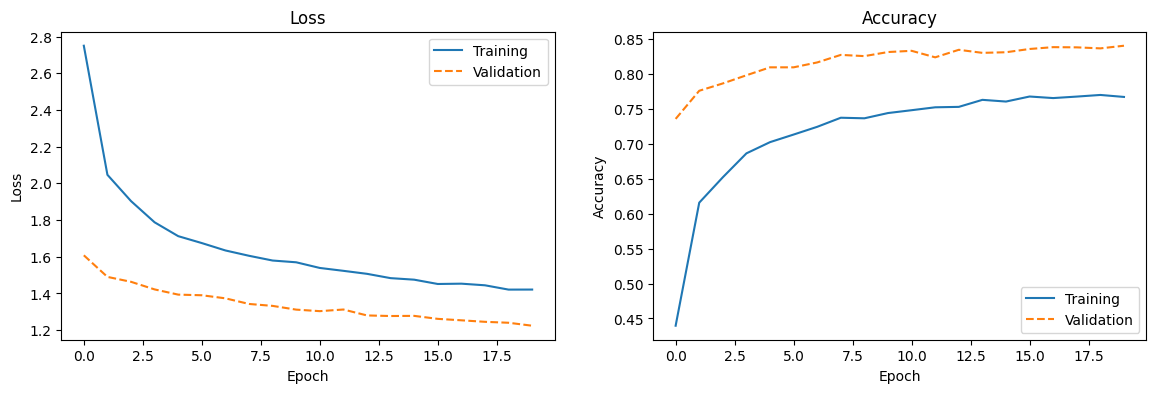

In [28]:
# TODO 7 (required) - plot training history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training')
plt.plot(val_accuracy, label='Validation', linestyle='--')
plt.legend()

plt.show()

## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [29]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [30]:
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)

In [31]:
# TODO 8 (optional) - you can decide how many layers to unfreeze

for layer in base_model.layers[:-6]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [32]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x791c95945ab0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x791c949541c0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x791c949bfb80>: False
<keras.src.layers.activation.relu.ReLU object at 0x791c949bf490>: False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x791c949bf730>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x791c948b5330>: False
<keras.src.layers.activation.relu.ReLU object at 0x791c948b60e0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x791c948b50f0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x791c948b7610>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x791c948b7ac0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x791c8f51c550>: False
<keras.src.layers.activation.re

Also, the model summary should now show more trainable parameters:

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                        

Re-compile your model. Don't forget to use a smaller learning rate for fine-tuning! We don't want to make major changes to the last feature extraction layers, we just want to adjust them a little bit.

In [34]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning

opt = Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)


Fit your model (with some newly unfrozen layers) for some more epochs.

In [36]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n

n_epochs_fine = 20
batch_size_fine = 64

hist_fine = model.fit(
    training_gen,
    epochs=n_epochs_fine,
    steps_per_epoch=training_gen.n//batch_size_fine,
    validation_data=validation_gen,
    validation_steps=validation_gen.n//batch_size_fine,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/20
154/154 [==============================] - ETA: 0s - loss: 1.1014 - accuracy: 0.8624

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


154/154 [==============================] - 91s 592ms/step - loss: 1.1014 - accuracy: 0.8624 - val_loss: 1.3972 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 2/20
154/154 [==============================] - 94s 610ms/step - loss: 1.0960 - accuracy: 0.8592 - val_loss: 1.2783 - val_accuracy: 0.8233 - lr: 1.0000e-04
Epoch 3/20
154/154 [==============================] - 91s 594ms/step - loss: 1.0957 - accuracy: 0.8567 - val_loss: 1.2801 - val_accuracy: 0.8163 - lr: 1.0000e-04
Epoch 4/20
154/154 [==============================] - 94s 610ms/step - loss: 1.0737 - accuracy: 0.8685 - val_loss: 1.2397 - val_accuracy: 0.8312 - lr: 1.0000e-04
Epoch 5/20
154/154 [==============================] - 91s 593ms/step - loss: 1.0639 - accuracy: 0.8634 - val_loss: 1.2773 - val_accuracy: 0.8189 - lr: 1.0000e-04
Epoch 6/20
154/154 [==============================] - 93s 603ms/step - loss: 1.0567 - accuracy: 0.8683 - val_loss: 1.2222 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 7/20
154/154 [===================

Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist_fine = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

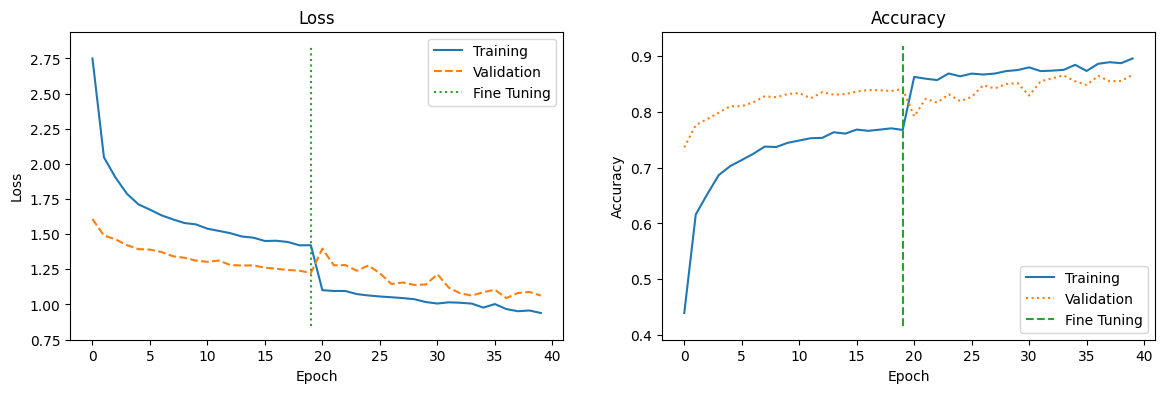

In [38]:
# TODO 11 (required) - plot training history
loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation', linestyle='--')
plt.plot([n_epochs-1, n_epochs-1], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training')
plt.plot(val_accuracy, label='Validation', linestyle='dotted')
plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

## Evaluate model performance


Once you have finished training your model, use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [ ]:
loss, accuracy = model.evaluate(evaluation_gen)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

We can also create a confusion matrix, to see which which classes are most often confused with one another.

In [40]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

105/105 [==============================] - 15s 137ms/step


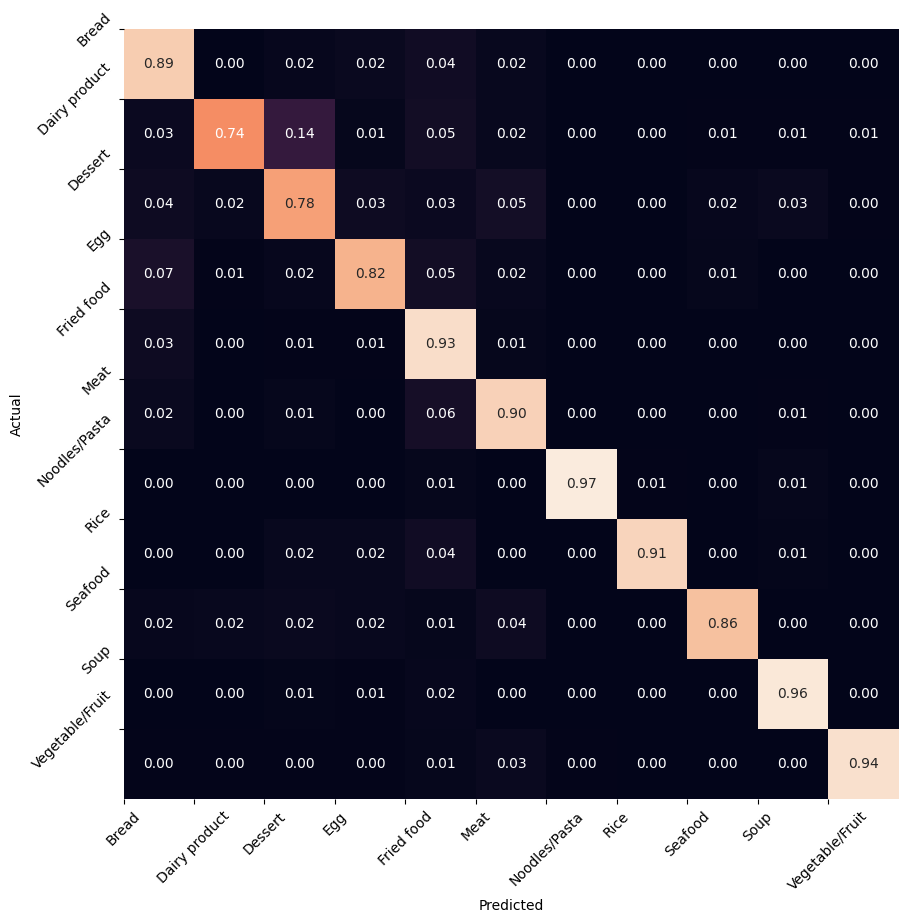

In [41]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11), labels=classes, rotation=45)

#### Calculate Precision, Recall, and F1 Score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(evaluation_gen.classes, y_pred, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(evaluation_gen.classes, y_pred, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(evaluation_gen.classes, y_pred, average='weighted')
print("F1-Score:", f1)

## Save your model

Use the following cell to save your model:

In [42]:
model.save("model.keras")

Then, download it for later use.

In [43]:
from google.colab import files
files.download('model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class.


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

### Extract the test folder with test images

In [ ]:
!gdown https://drive.google.com/uc?id=15GxbVLr7TM5Mfowh9StpOIhV0KMKobNe

In [ ]:
!unzip test-images.zip

#### Extracting a food image taken in my phone

In [ ]:
!gdown https://drive.google.com/uc?id=1XzfQeEcfoBpBDeBbrIKWTcLywRcw57RR

1/1 [==============================] - 0s 23ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/329534469.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


[Text(0, 0, 'Dessert'),
 Text(1, 0, 'Bread'),
 Text(2, 0, 'Dairy product'),
 Text(3, 0, 'Fried food'),
 Text(4, 0, 'Vegetable/Fruit')]

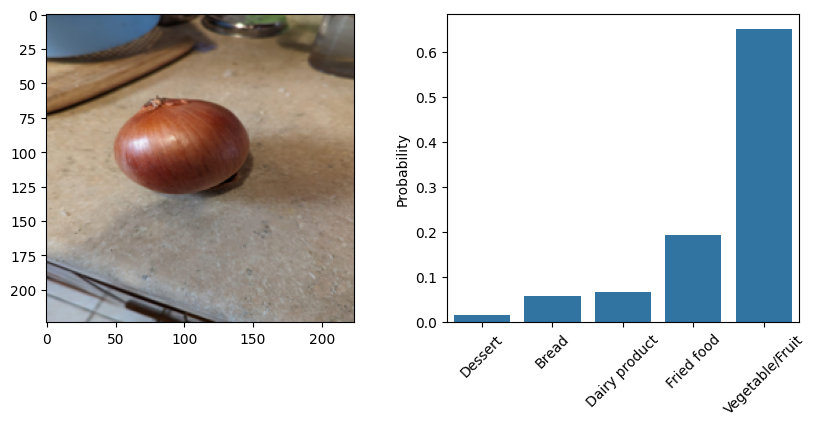

In [8]:
# TODO 12 (required) - show example of model use on a new image
im = Image.open('onion.jpeg').convert('RGB')
image_resized = im.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)/255.0
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

test_probs = model.predict(test_sample)

most_likely_classes = np.argsort(test_probs.squeeze())[-5:]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3))

plt.subplot(1,2,2)
p = sns.barplot(x=classes[most_likely_classes], y=test_probs.squeeze()[most_likely_classes])
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45)

#### Testing out the model on sample food images from the internet

1/1 [==============================] - 0s 35ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


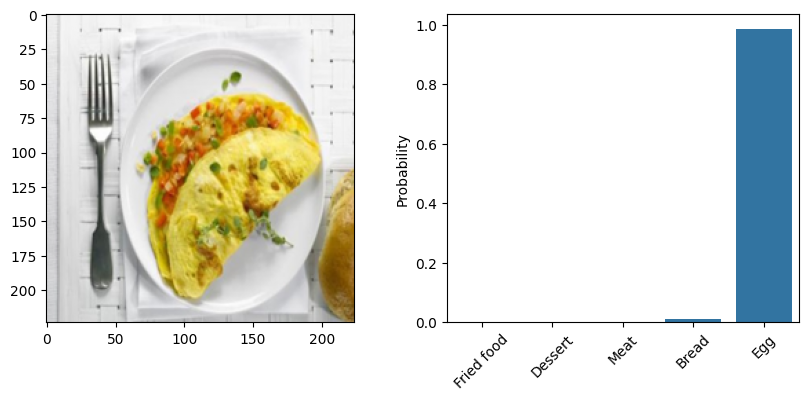

1/1 [==============================] - 0s 27ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


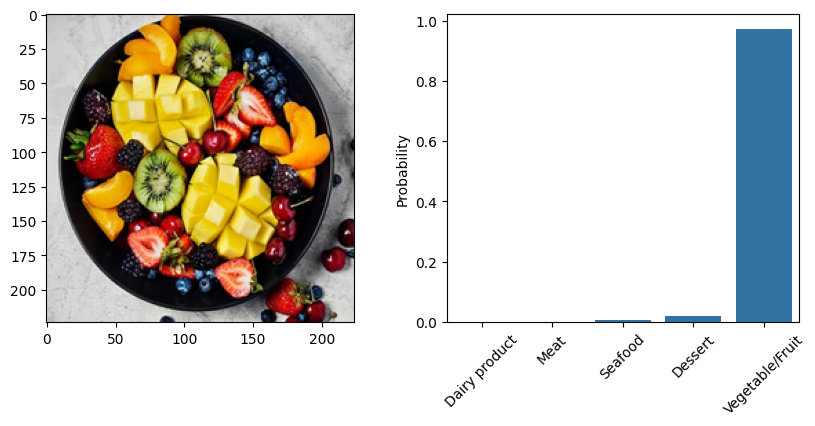

1/1 [==============================] - 0s 24ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


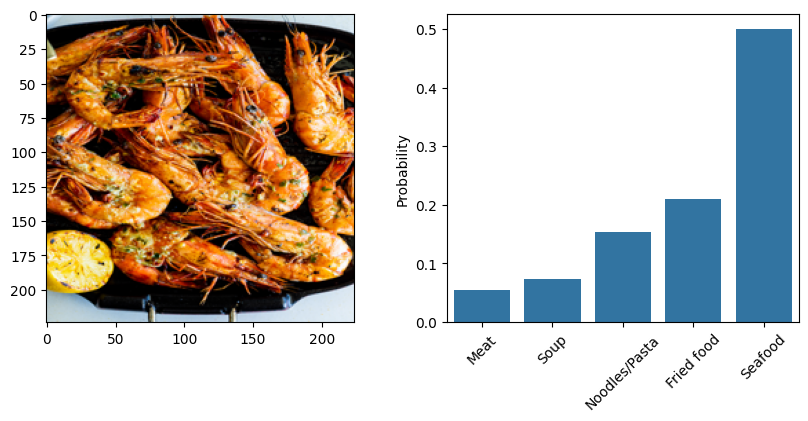

1/1 [==============================] - 0s 28ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


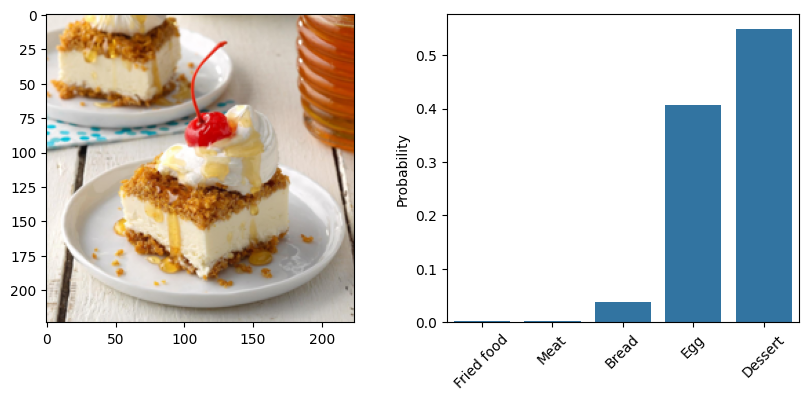

1/1 [==============================] - 0s 23ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


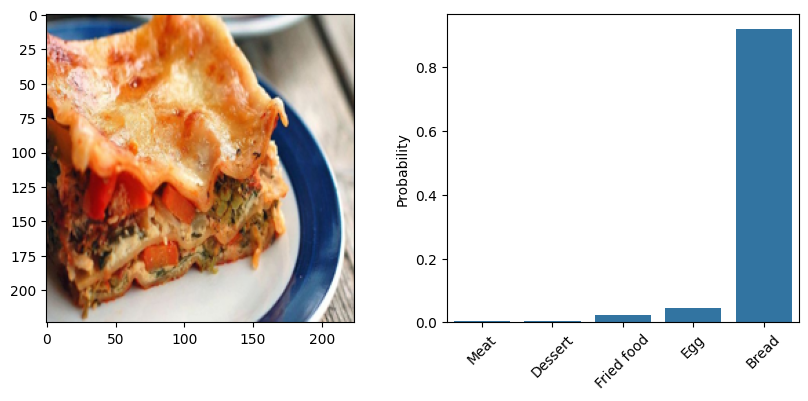

1/1 [==============================] - 0s 25ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


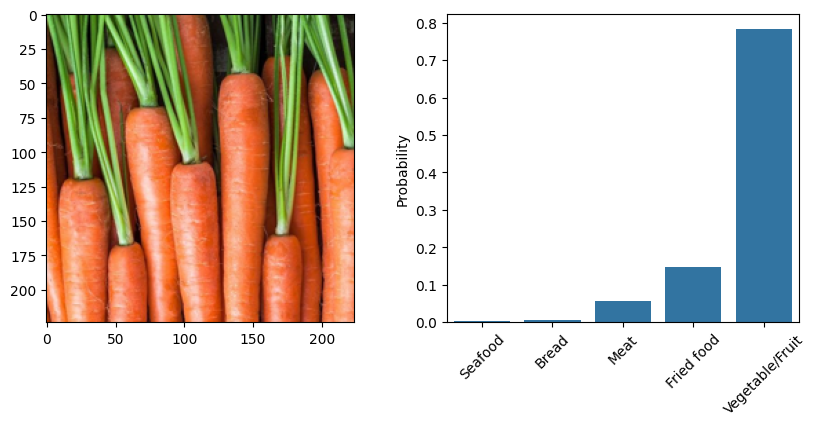

1/1 [==============================] - 0s 24ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


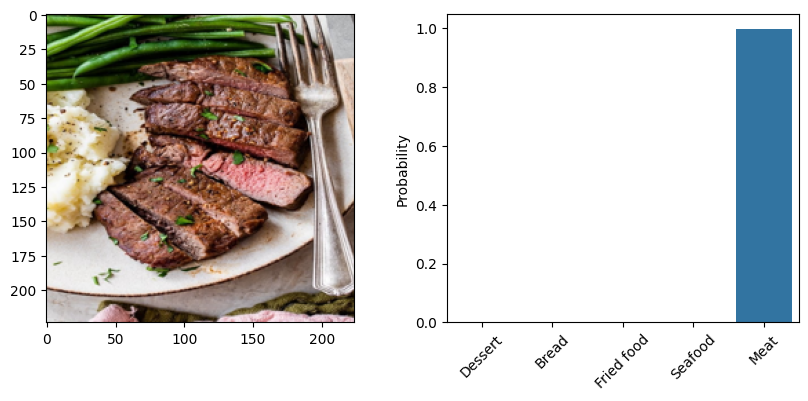

1/1 [==============================] - 0s 47ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


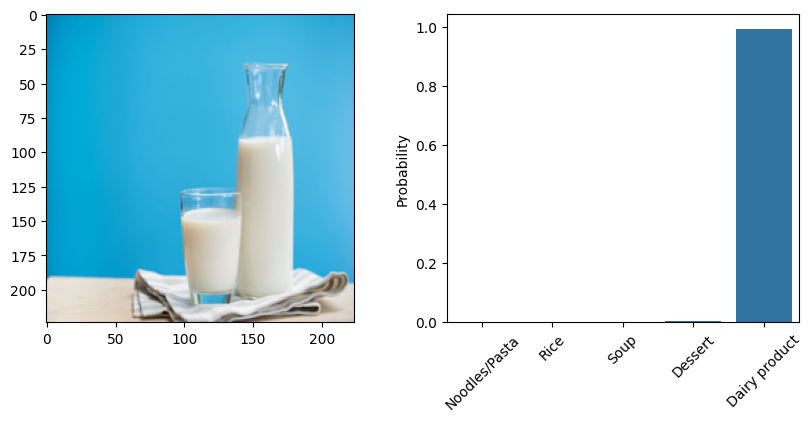

1/1 [==============================] - 0s 24ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


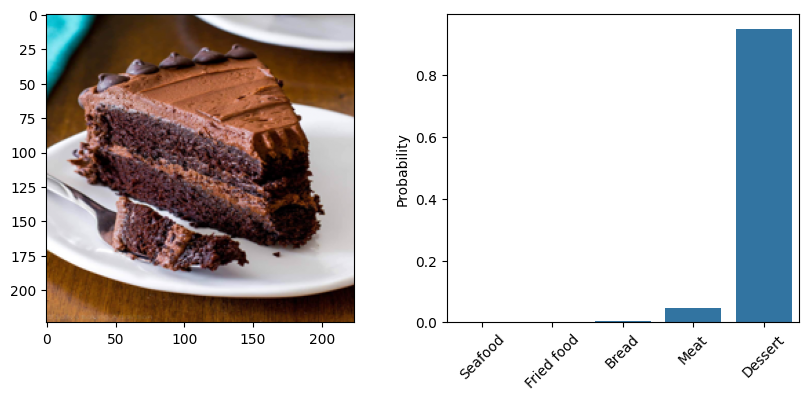

1/1 [==============================] - 0s 47ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


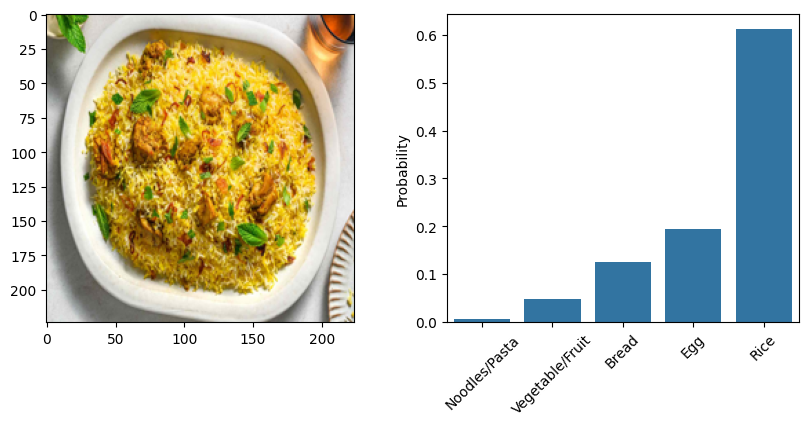

1/1 [==============================] - 0s 28ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


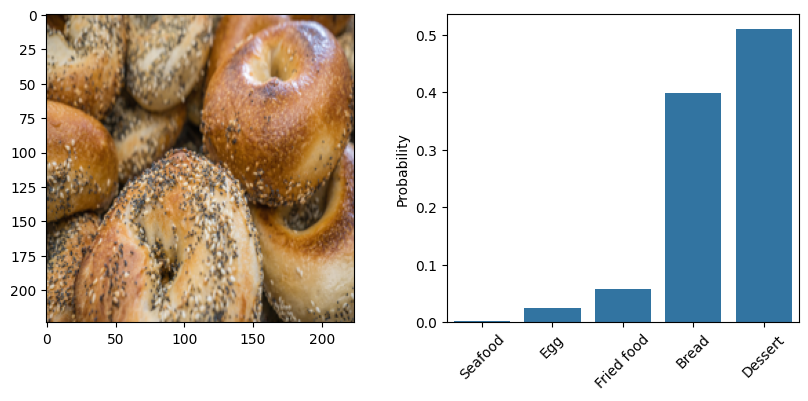

1/1 [==============================] - 0s 25ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


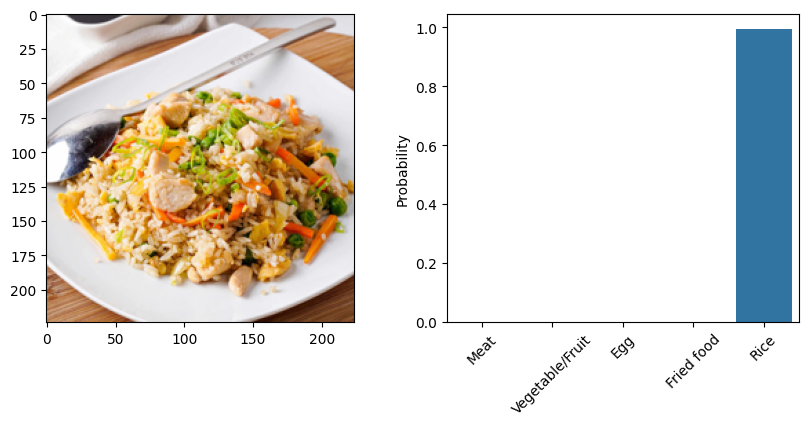

1/1 [==============================] - 0s 35ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


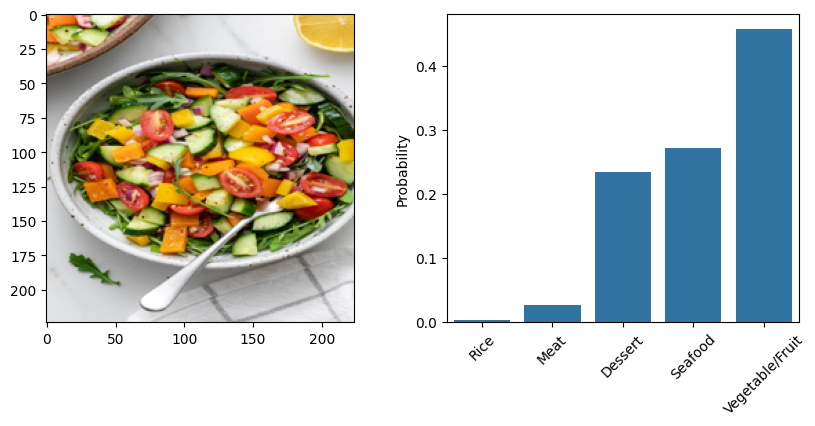

1/1 [==============================] - 0s 25ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


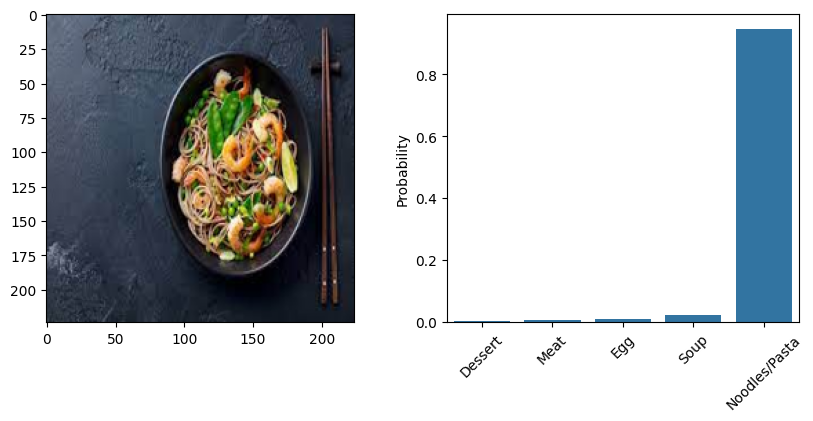

1/1 [==============================] - 0s 41ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


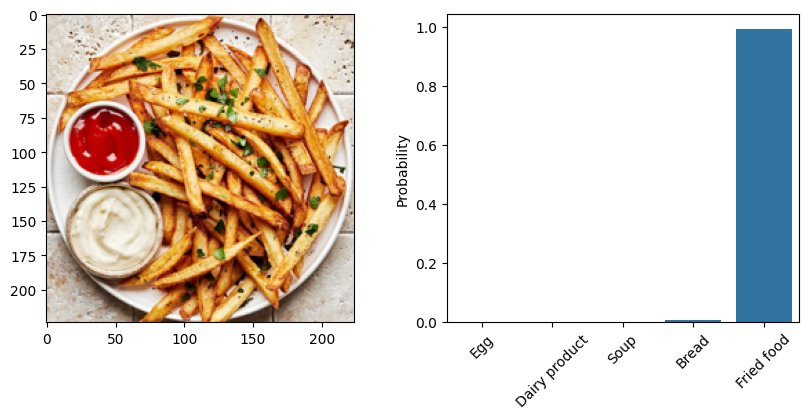

1/1 [==============================] - 0s 23ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


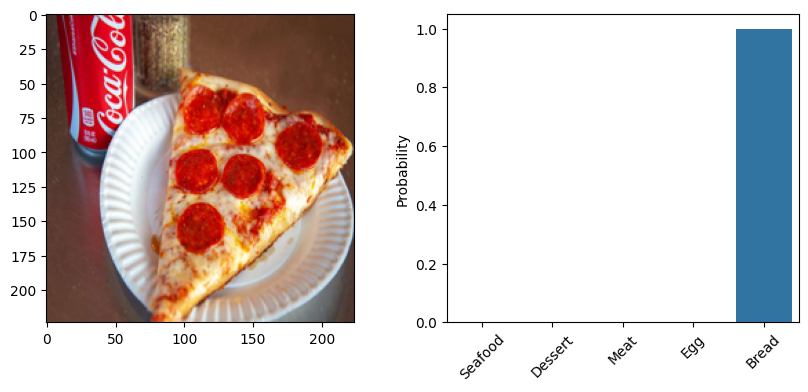

1/1 [==============================] - 0s 37ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


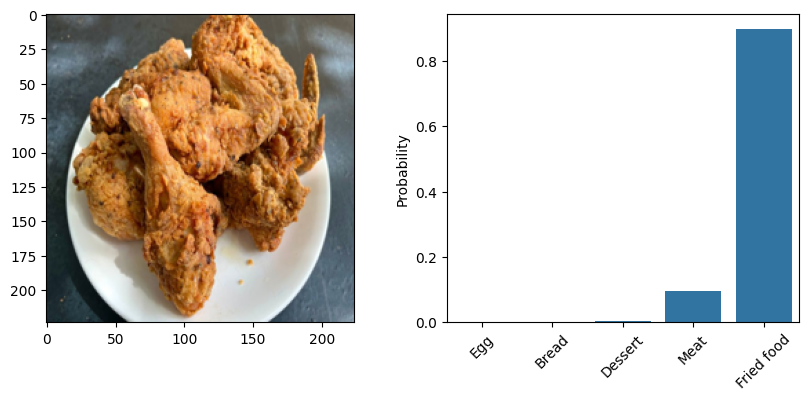

1/1 [==============================] - 0s 23ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


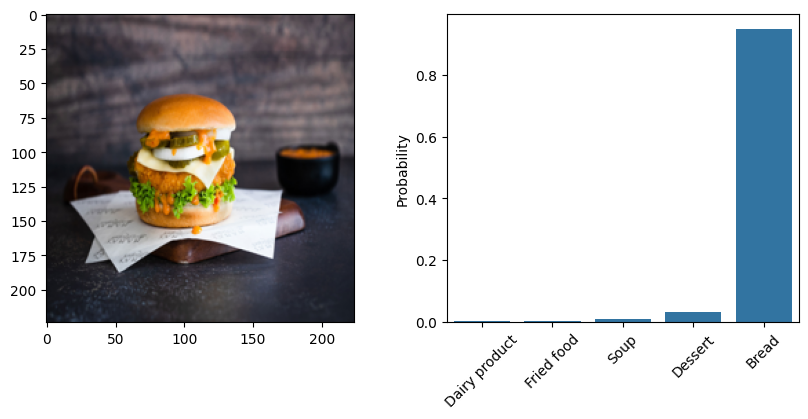

1/1 [==============================] - 0s 23ms/step


/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_3047/1993583362.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


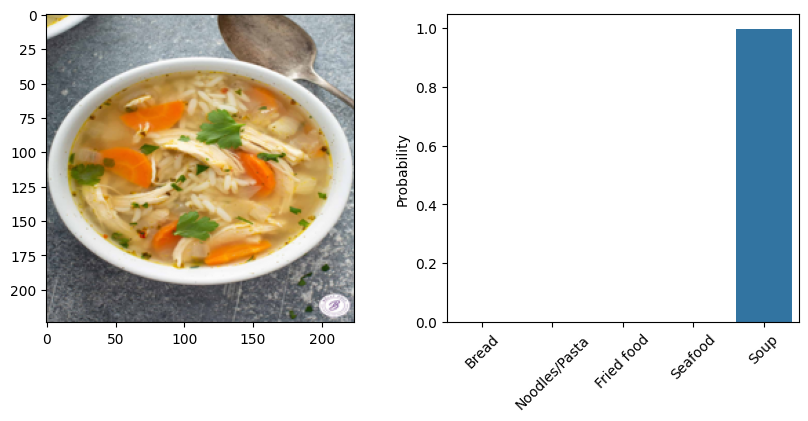

In [10]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' and 'classes' have been defined earlier in the code
# Make sure to define INPUT_IMG_SIZE and classes before using them

def process_and_predict(image_path):
    """
    Process the image and predict the class probabilities.
    """
    im = Image.open(image_path).convert('RGB')
    image_resized = im.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
    test_sample = np.array(image_resized) / 255.0
    test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

    test_probs = model.predict(test_sample)
    return test_sample, test_probs

def plot_results(test_sample, test_probs):
    """
    Plot the image and the probabilities of the top 5 classes.
    """
    most_likely_classes = np.argsort(test_probs.squeeze())[-5:]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3))

    plt.subplot(1, 2, 2)
    p = sns.barplot(x=classes[most_likely_classes], y=test_probs.squeeze()[most_likely_classes])
    plt.ylabel("Probability")
    p.set_xticklabels(p.get_xticklabels(), rotation=45)
    plt.show()

# Replace with the path to your folder in Google Colab
folder_path = 'content/test-images/'

# Processing each image in the folder
for image_file in os.listdir(folder_path):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check if the file is an image
        image_path = os.path.join(folder_path, image_file)
        test_sample, test_probs = process_and_predict(image_path)
        plot_results(test_sample, test_probs)

## Describe your model - TODO 13 (required)

In the following cell, describe your final model and your results, by answering the following questions.

* What base model did you use? How many parameters does this base model have?
  - The base model I used was MobileNetV2.
  - The total number of parameters in the MobileNetV2 base model is 2,257,984. Of these, 2,223,872 are trainable parameters, and 34,112 are non-trainable parameters.

* Describe the specific transformations you used to create an augmented data set.
  - To augment the dataset, the following transformations were applied:
    - Rescaled pixel values by 1/255 to bring them into the range [0, 1].
    - Applied a rotation range of 20 degrees for random rotation.
    - Applied a zoom range of 0.2 for moderate zooming in and out.
    - Shifted the image width and height by 20% for both width and height.
    - Sheared the image by 0.2.
    - Applied horizontal flips to the images.
    - Utilized the "nearest" fill mode to fill in new pixels that may be created by rotations or width/height shifts.


* For how many epochs did you train your classification head, and with what optimizer, learning rate, and batch size? What was the validation accuracy at the end of this training stage?
  - The classification head was trained for 20 epochs
  - Optimizer: Adam
  - Learning rate: 0.0005
  - Batch size: 32.
  - Accuracy at the end of this training stage: 84.08%

* Which layers did you un-freeze for fine-tuning, how many epochs did you fine-tune for, and what optimizer, learning rate, and batch size did you use for fine-tuning? What was the validation accuracy at the end of this training stage?
  - The last 5 layers of the base model were unfrozen and made trainable. The fine-tuning was carried out for an additional 20 epochs.
  - Optimizer: Adam
  - Learning rate: 0.0001
  - Batch size: 64.
  - Accuracy at the end of this training stage: 86.59%

* What was your final accuracy on the evaluation set?
  - Final Accuracy: 87.87%

* Did your model correctly predict the class of your custom test image?
  - Yes